# Calculation of Muon's range in LAr using finite differencing method (Version 2.0)

In [24]:
#Import necesary modules to run the code
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
   
from matplotlib import rc
import matplotlib
# from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)
                                                 
import math
import scipy
from scipy import integrate
from scipy import optimize
from scipy.optimize import fsolve
from numpy import sqrt, sin, cos, pi
import csv
import time


<font size=5>
Momentum of Proton, 
$$
p = \frac{mc\beta}{\sqrt{1-\beta^{2}}} 
$$

Cerenkov angle can be calculated from,
$$
cos\theta = \frac{1}{\beta n}= \frac{\sqrt{(1+\frac{m^{2}c^{2}}{p^{2}})}}{n} = \frac{\sqrt{(1+\frac{mc^{2}}{2T})}}{n}
$$

where, $\theta$ is the Cerenkov angle

The average energy loss per unit length for proton travelling in LAr can be found from the Bethe-Bloch equation, 
$$
-\frac{dE}{dx} = K\frac{\rho Z}{A} \frac{z^2}{\beta^2} [ln \space (\frac{2m_{e}c^2\gamma^2\beta^2}{I}) - \beta^2] = \frac{k_{1}}{\beta^2} ln(k_{2} \frac{\beta^2}{1-\beta^2}) - k_{1}
$$

Here, 
$ k_{1} =  K\frac{\rho Z}{A} z^2 $ and  $ k_{2} = \frac{2m_{e}c^2}{I} $

where, z is the charge of the travelling proton; $\rho$ is the density of LAr, Z is its atomic number and A atomic mass. 

Mean excitation potential For LAr, I = 23.6 eV 

The constant K is given by, 

$$ K = \frac{4\pi a^2 (\hbar c)^2 N_{A} (10^3 kg)}{m_{e} c^2} = 30.7 \space keVm^2/kg = 0.0307 \space MeVm^2/kg = 0.307 \space MeVcm^2/g $$ 
    
Non-relativistic approx: 
    
The kinetic energy of the proton is approximated with the classical formula, 
    
$$ 
T = \frac{1}{2} mv^2 = \frac{1}{2} mc^2 \beta^2 
$$

Therefore, $$\beta = \sqrt{\frac{2T}{mc^2}}$$
    
Relativistic approach:
    
We take the full relativistic formula for the kinetic energy (T) thus $\beta$,  

$$ T = \gamma mc^2 - mc^2 = (\gamma - 1) mc^2 $$  
$$ \gamma = 1 + \frac{T}{mc^2} = \frac{1}{\sqrt{(1- \beta^2)}} $$

$$
\beta = \sqrt{1 - \frac{1}{(1 + \frac{T}{mc^2})^2}} 
$$

1.)  Relativistic vs nonrelativistic Bethe-Bloch
2.)  NIST vs Bethe-Bloch (stopping power curves)
***  Decision:  Which curve is best to use for the Cerenkov emission?


In [2]:
rho = 1.38 #density of LAr in kg/m^3 at 89K temperature  
me = 9.11e-31 #Electron's mass in Kg.
io = 23.6e-6  #Average Ionization Potential of LAr in MeV
k =  0.307  #Constant in MeV.cm^2/g 
zb = 18  #Atomic No of Ar (absorber)
a = 39.948  #Mass no of Ar (absorber)
zs = -1 #charge of the particle 
c = 3e8
e = me*c**2/1.602e-13 #m(e)c^2 in MeV (1 MeV = 1.602e-13 J) #Electron's mass in MeV (the hit particle)
# mp = 938 #Proton's mass in MeV/c^2 
mm = 105.66 #Muon rest mass ~ 105.7 MeV/c²

k1 = k*rho*zb*zs**2/a
k2 = 2*e/io 

e,mm,k1,k2

(0.5117977528089888, 105.66, 0.19089516371282667, 43372.69091601599)

In [3]:
#coeff: 

N = 6.023e11
e = 1.67e-19      #me*c**2/1.602e-13 #m(e)c^2 in MeV (1 MeV = 1.602e-13 J) #Electron's mass in MeV (the hit particle)
c = 3e8 #in vacuum 
me = 9.11e-31 #Electron's mass in Kg.
elec_const = 9e9

a_pvs = 0.00029

coeff1 = (2*N*e**2*elec_const)/(2*me*c)
coeff2 = a_pvs*2*np.pi*c

coeff1, coeff2, coeff1*2

(553157.34467618, 546637.121724624, 1106314.68935236)

In [4]:
Np = coeff2*(2*me*c)/(e**2*elec_const)
Np

1190401037185.8257

In [41]:
#Calculating the distance travelled by Proton (with given initial K.E) in LAr
# xlist = np.linspace(0,199.9,2000) 

t = 100 #initial K.E of the proton in MeV 
# t = np.array([1,10,20,50,100,200,250,300,400,500,600,700,800,900,1000]) #initial  K.E of the proton in MeV

dx = 0.1 #in cm 

xlist1 = []
tlist1 = [] 
tslope1 = []

xlist2 = []
tlist2 = []
tslope2 = []


x = 0
t1 = t

while t1>0: 
    beta = np.sqrt(2*t1/mm) #Non relativistic approximation
    t_slope = (((k1*np.log(k2*(beta**2/(1-beta**2))))/beta**2) - k1)
    tslope1.append(t_slope)
    t1 = t1 - (t_slope * dx)
    tlist1.append(t1)

    x=x+dx    
    xlist1.append(x) 

t2 = t
x = 0

while t2>0:
    beta  = np.sqrt(1 - (1/(1 + t2/mm)**2)) #Relativistic Approach 
    t_slope = (((k1*np.log(k2*(beta**2/(1-beta**2))))/beta**2) - k1)
    tslope1.append(t_slope)
    t2 = t2 - (t_slope * dx)
    tlist2.append(t2) 

    x=x+dx    
    xlist2.append(x)

#run while loop -> while loop untill T becomes negative -> linear interpolation between last 2 points (1 positive and one negative) -> value of range 


C:\Users\Hasan's PC\AppData\Local\Temp\ipykernel_7216\804297941.py:23: RuntimeWarning: invalid value encountered in log
  t_slope = (((k1*np.log(k2*(beta**2/(1-beta**2))))/beta**2) - k1)


((array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
  [Text(0, -20.0, '$\\mathdefault{−20}$'),
   Text(0, 0.0, '$\\mathdefault{0}$'),
   Text(0, 20.0, '$\\mathdefault{20}$'),
   Text(0, 40.0, '$\\mathdefault{40}$'),
   Text(0, 60.0, '$\\mathdefault{60}$'),
   Text(0, 80.0, '$\\mathdefault{80}$'),
   Text(0, 100.0, '$\\mathdefault{100}$'),
   Text(0, 120.0, '$\\mathdefault{120}$')]),
 (array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
  [Text(-5.0, 0, '$\\mathdefault{−5}$'),
   Text(0.0, 0, '$\\mathdefault{0}$'),
   Text(5.0, 0, '$\\mathdefault{5}$'),
   Text(10.0, 0, '$\\mathdefault{10}$'),
   Text(15.0, 0, '$\\mathdefault{15}$'),
   Text(20.0, 0, '$\\mathdefault{20}$'),
   Text(25.0, 0, '$\\mathdefault{25}$'),
   Text(30.0, 0, '$\\mathdefault{30}$')]))

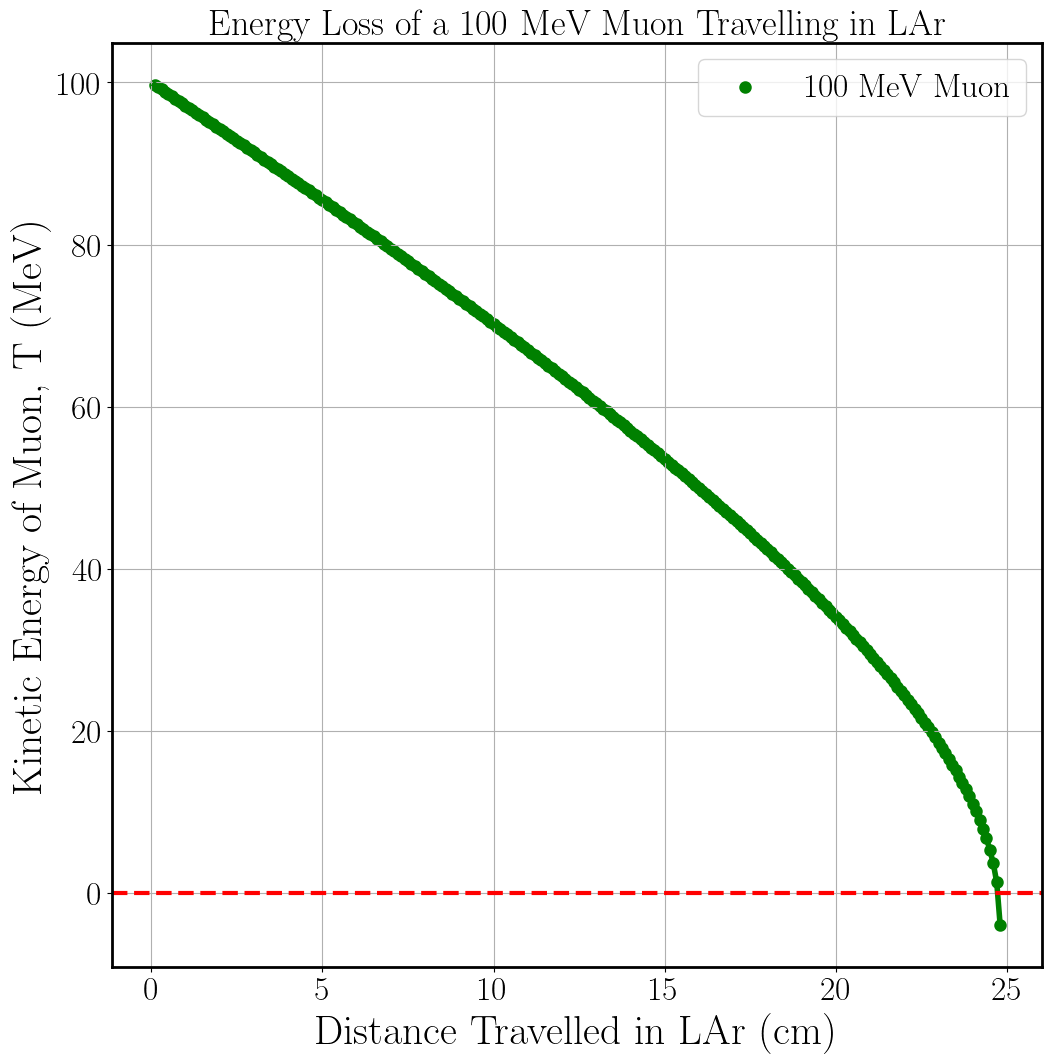

In [42]:
#Plotting the distance travelled by Muon (with given initial K.E) in LAr:  

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

#TeX up labels and text:

plt.rc("text", usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{graphicx}'
plt.rc('font', size=24) 
plt.rc('font', family='serif')

#     matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
#     plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=2)

ax.set_title("Energy Loss of a 100 MeV Muon Travelling in LAr", fontsize=26)
# ax.scatter(xlist,tlist)
# ax.scatter(xlist1,tlist1, c='purple',label='non-relativistic',lw=3)
ax.scatter(xlist2, tlist2, c='green',label='100 MeV Muon',lw=3) #'relativistic'

#Continuous plot: 
# ax.plot(xlist1,tlist1, c='purple',lw=4) #label='non-relativistic'
ax.plot(xlist2, tlist2, c='green', lw=4) #label='relativistic'
plt.axhline(0,ls='--',c='red',lw=3)

ax.grid()

ax.set_ylabel("Kinetic Energy of Muon, T (MeV)",fontsize=30)
ax.set_xlabel('Distance Travelled in LAr (cm)',fontsize=30)

plt.legend(fontsize=24)

plt.yticks(fontsize=24), plt.xticks(fontsize=24)

# plt.savefig("KEloss_Muon_100MeV_LAr.jpg", bbox_inches= 'tight')
# plt.show()


In [8]:
#Calculating the distance travelled by Proton (with given initial K.E) in LAr
# xlist = np.linspace(0,199.9,2000) 

t = 500 #initial K.E of the proton in MeV 
# t = np.array([1,10,20,50,100,200,250,300,400,500,600,700,800,900,1000]) #initial  K.E of the proton in MeV

dx = 0.1 #in cm 

xlist1 = []
tlist1 = [] 
tslope1 = []

xlist2 = []
tlist2 = []
tslope2 = []


x = 0
t1 = t

while t1>0: 
    beta = np.sqrt(2*t1/mm) #Non relativistic approximation
    t_slope = (((k1*np.log(k2*(beta**2/(1-beta**2))))/beta**2) - k1)
    tslope1.append(t_slope)
    t1 = t1 - (t_slope * dx)
    tlist1.append(t1)

    x=x+dx    
    xlist1.append(x) 

t2 = t
x = 0

while t2>0:
    beta  = np.sqrt(1 - (1/(1 + t2/mm)**2)) #Relativistic Approach 
    t_slope = (((k1*np.log(k2*(beta**2/(1-beta**2))))/beta**2) - k1)
    tslope1.append(t_slope)
    t2 = t2 - (t_slope * dx)
    tlist2.append(t2) 

    x=x+dx    
    xlist2.append(x)

#run while loop -> while loop untill T becomes negative -> linear interpolation between last 2 points (1 positive and one negative) -> value of range 


C:\Users\Hasan's PC\AppData\Local\Temp\ipykernel_7216\928043180.py:23: RuntimeWarning: invalid value encountered in log
  t_slope = (((k1*np.log(k2*(beta**2/(1-beta**2))))/beta**2) - k1)


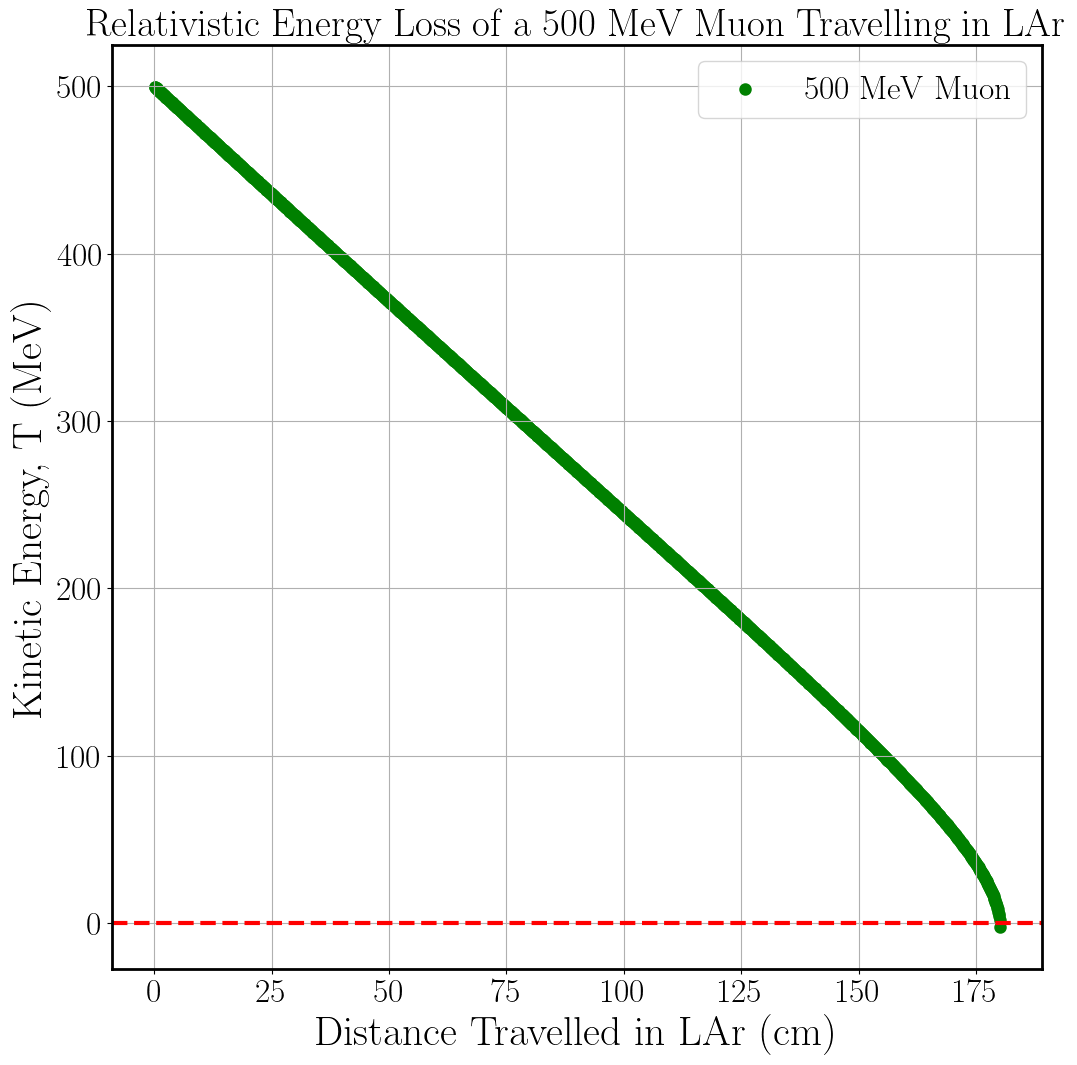

In [17]:

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

#TeX up labels and text:

plt.rc("text", usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{graphicx}'
plt.rc('font', size=24) 
plt.rc('font', family='serif')

#     matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["font.weight"] = "bold"     
#     plt.rcParams["axes.labelweight"] = "bold"
plt.rc('axes', linewidth=2)

ax.set_title("Relativistic Energy Loss of a 500 MeV Muon Travelling in LAr", fontsize=28)
# ax.scatter(xlist,tlist)
# ax.scatter(xlist1,tlist1, c='purple',label='non-relativistic',lw=3)
ax.scatter(xlist2, tlist2, c='green', lw=3, label= '500 MeV Muon')
plt.axhline(0,ls='--',c='red',lw=3)


#Continuous plot: 
# ax.plot(xlist1,tlist1, c='purple',lw=4) #label='non-relativistic'
# ax.plot(xlist2, tlist2, c='green', lw=4) #label='relativistic'

ax.grid()

ax.set_ylabel("Kinetic Energy, T (MeV)",fontsize=30)
ax.set_xlabel('Distance Travelled in LAr (cm)',fontsize=30)

plt.legend(fontsize=24)

plt.yticks(fontsize=24), plt.xticks(fontsize=24)

# plt.savefig("KEloss_Muon_500MeV_LAr.jpg") #, bboxes_inches= 'tight'
# plt.show()


In [12]:
#Calculating the distance travelled by Proton (with given initial K.E) in LAr
t = 500 #initial K.E of the proton in MeV 
dx = 0.1

xlist1 = []
tlist1 = [] 
tslope1 = []

xlist2 = []
tlist2 = []
tslope2 = []

t2 = t
x = 0

while t2>0:
    beta  = np.sqrt(1 - (1/(1 + t2/mm)**2)) #Relativistic Approach 
    t_slope = (((k1*np.log(k2*(beta**2/(1-beta**2))))/beta**2) - k1)
    t2 = t2 - (t_slope * dx)
    tlist2.append(t2) 
    x=x+dx    
    xlist2.append(x)


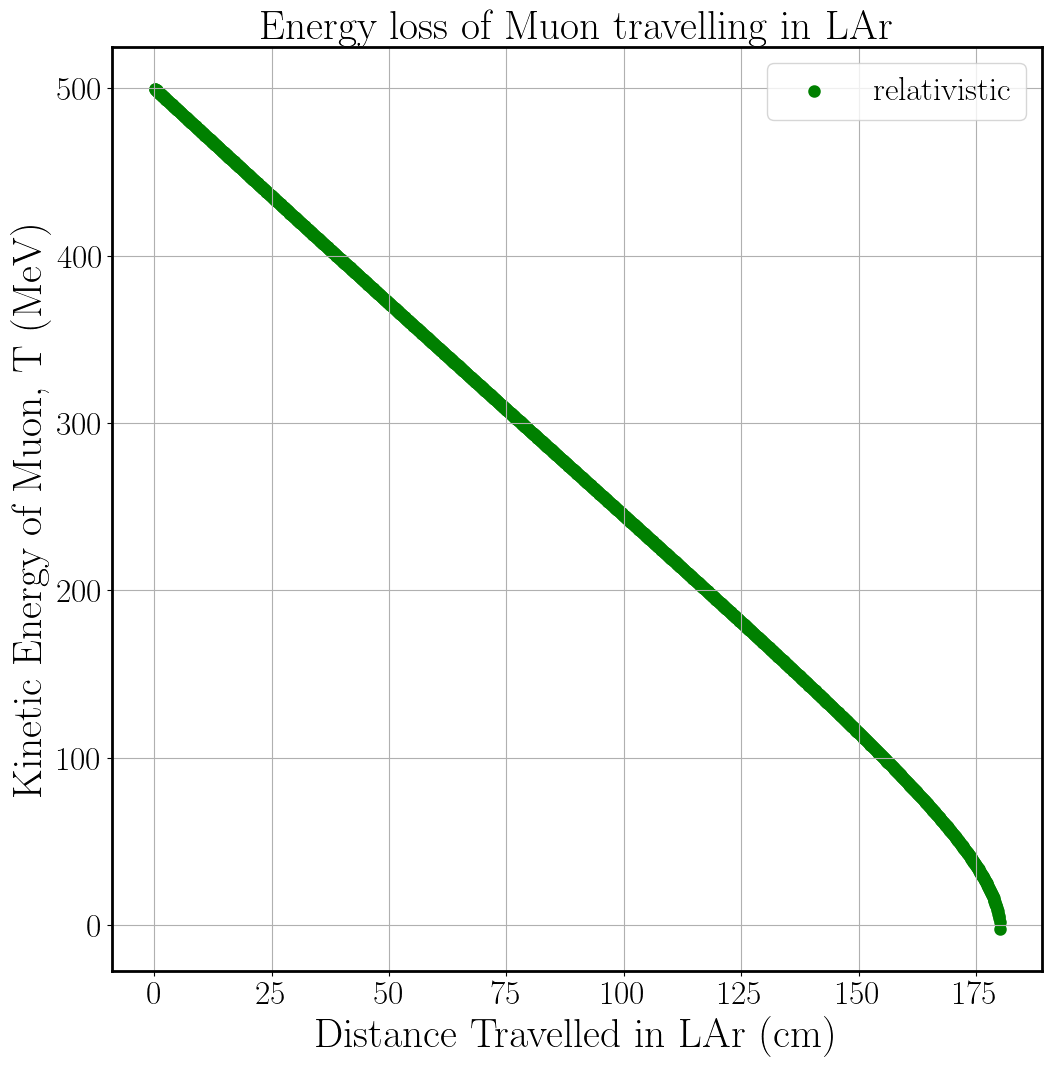

In [16]:
# #Plotting the distance travelled by Proton (with given initial K.E) in LAr:  

# fig = plt.figure(figsize=(12,12))
# ax = fig.add_subplot(111)
# ax.set_title("Energy loss of Muon travelling in LAr", fontsize=30)
# # plt.scatter(xlist1,tlist1, c='blue',label='non-relativistic',lw=3)
# plt.scatter(xlist2, tlist2, c='green',label='relativistic',lw=3)
# plt.grid()

# ax.set_ylabel("Kinetic Energy of Muon, T (MeV)",fontsize=30)
# ax.set_xlabel('Distance Travelled in LAr (cm)',fontsize=30)
# plt.legend(fontsize=24)

# plt.yticks(fontsize=24), plt.xticks(fontsize=24)

# plt.savefig("KEloss_Muon_500MeV_LAr.jpg")
# plt.show()

<font size=4>

## Linear Interpolation: 

This method was used to determine the total distance travelled (i.e range) by Proton in LAr before its K.E becomes zero. As in the CSDA, K.E falls off sharply to zero so we applied the simplest interpolation formula to effectively determine the x-value for which the K.E is zero. In this method, the last two data points have been used for x and T (one posive and one negative value) to find the x for which T = 0. 

Let's suppose these two datapoints (the two green points on the lower right: one above and one below the T = 0 axis) are labelled as $(x_{n-1}, T_{n-1})$ and $(x_{n}, T_{n})$. Then. the straightline joining these two points are given by, 

$$
T - T_{n-1} = (\frac {T_{n} - T_{n-1}}{x_{n} - x_{n-1}}) . (x - x_{n-1}) 
$$ 

Now setting T = 0 in the above equation will give us the range of the Proton i.e x = R (range), 

$$
R = x_{n-1} - T_{n-1} . (\frac {x_{n} - x_{n-1}} {T_{n} - T_{n-1}}) 
$$ 

I have used this linear interpolation method to determine the range of Proton in LAr using various methods: 
    
    1. Non-relativistic method 1: classical K.E and exact B-B formula (Purple curve) 
    2. Non-relativistic method 2: classical K.E and approx B-B formula (Blue curve)
    3. NIST (Orange curve)
    4. Relativistic approach (Green curve)

In [ ]:
# #import data:
# alldata = np.genfromtxt('range_muon.txt',delimiter='\t',skip_header=1)
# data_t, data_x_lb, data_x_db, data_x_or, data_x_gr = np.transpose(alldata)[0], np.transpose(alldata)[1], np.transpose(alldata)[2],  np.transpose(alldata)[3],  np.transpose(alldata)[4]

# data_t, data_x_lb, data_x_db, data_x_or, data_x_gr

In [30]:
#Calculating range of Proton of different initial KE travelling in LAr: 

# t = 300
t = np.array([10,20,50]) #,100,200,250,300,400,500,600,700,800,900,1000]) #initial  K.E of the proton in MeV
t = np.array([5,10,15,20,25,30,35,40,45,50])

def make_range(tl):
    ''' tl = t_list input from data'''
    
    xlist1 = []
    tlist1 = []
    tslope1 = []
    betalist1 = []

    xlist2 = []
    tlist2 = []
    tslope2 = []
    betalist2 = []

#     t = np.array([1,10,20,50,100,200,250,300,400,500,600,700,800,900,1000]) #initial  K.E of the proton in MeV
    
    x = 0
    dx = 0.1

    t1 = tl

    while t1>0: 
        beta = np.sqrt(2*t1/mm) #Non relativistic approximation
        t_slope = (((k1*np.log(k2*(beta**2/(1-beta**2))))/beta**2) - k1)
        t1 = t1 - (t_slope * dx)
        tslope1.append(t_slope)
        tlist1.append(t1)
        

        x=x+dx    
        xlist1.append(x) 

    t2 = tl
    x = 0

    while t2>0:
        beta  = np.sqrt(1 - (1/(1 + t2/mm)**2)) #Relativistic Approach 
        t_slope = (((k1*np.log(k2*(beta**2/(1-beta**2))))/beta**2) - k1)
        t2 = t2 - (t_slope * dx)
        tslope2.append(t_slope)
        tlist2.append(t2)
        betalist2.append(beta)

        x=x+dx    
        xlist2.append(x)
    
        
#     return xlist1,tlist1,xlist2,tlist2
    
    #Linear Interpolation: 

    if (len(tlist1)>1) and (len(tlist2)>1) and (len(xlist1)>1) and (len(xlist2)>1):
    
        tn1 = tlist1[-1]
        tn2 = tlist1[-2]
        tnp1 = tlist2[-1]
        tnp2 = tlist2[-2]
        xn1 = xlist1[-1]
        xn2 = xlist1[-2]
        xnp1 = xlist2[-1]
        xnp2 = xlist2[-2]
        # print(xlist[-2],tlist[-2])
        # print(xlist[-1],tlist[-1])

        range1 = xn2 - (tn2 * ((xn1-xn2)/(tn1 - tn2))) #Non-rel approx
        range2 = xnp2 - (tnp2 * ((xnp1-xnp2)/(tnp1 - tnp2))) #Relativistic approach 

        print("K.E: {} MeV, Range (Non-rel apprx):  {:.3f} cm, Range (Rel approach): {:.3f} cm".format(tl,range1,range2))
#         print((tlist1,tslope1) , (tlist2, tslope2))
               
        return range1,range2     
#         return betalist2
    
# betalist2
        
        
# #call the function:

nonrel_list, rel_list = [], []

# # for i in range(len(data_t)):
for a in t:   #data_t[1:9]
    # nrl,rl = make_range(a) 
    range1,range2 = make_range(a)
    # print(a, make_range(a))
    tslope1,tslope2
    # nonrel_list.append(nrl), rel_list.append(rl)  #nrl- non-relativistic & rl- relativistic
    nonrel_list.append(range1), rel_list.append(range2)  #nrl- non-relativistic & rl- relativistic
#     ratio = nonrel_list / rel_list  #Ratio of x_classical & x_relativistic



K.E: 5 MeV, Range (Non-rel apprx):  0.213 cm, Range (Rel approach): 0.207 cm
K.E: 10 MeV, Range (Non-rel apprx):  0.672 cm, Range (Rel approach): 0.616 cm
K.E: 15 MeV, Range (Non-rel apprx):  1.353 cm, Range (Rel approach): 1.209 cm
K.E: 20 MeV, Range (Non-rel apprx):  2.268 cm, Range (Rel approach): 1.955 cm
K.E: 25 MeV, Range (Non-rel apprx):  3.401 cm, Range (Rel approach): 2.832 cm
K.E: 30 MeV, Range (Non-rel apprx):  4.730 cm, Range (Rel approach): 3.829 cm
K.E: 35 MeV, Range (Non-rel apprx):  6.273 cm, Range (Rel approach): 4.929 cm
K.E: 40 MeV, Range (Non-rel apprx):  7.995 cm, Range (Rel approach): 6.120 cm
K.E: 45 MeV, Range (Non-rel apprx):  9.853 cm, Range (Rel approach): 7.401 cm
K.E: 50 MeV, Range (Non-rel apprx):  11.813 cm, Range (Rel approach): 8.732 cm


In [31]:
make_range(25)

K.E: 25 MeV, Range (Non-rel apprx):  3.401 cm, Range (Rel approach): 2.832 cm


(3.4011428845829905, 2.8319901537647896)

In [32]:
# tlist2

In [33]:
#find the difference:

for a,b in zip(nonrel_list,rel_list):
    diff = np.abs((a-b)/b)
    print(diff)
    if diff > 0.1:
        print(a,b)

np.where(np.abs(nonrel_list)-np.abs(rel_list)>0.1)

0.0293762740065846
0.09000705060975658
0.11937344247612025
1.3530832417132894 1.2087862641445104
0.15989868284365436
2.2679630111669082 1.955311308403833
0.20097270820718816
3.4011428845829905 2.8319901537647896
0.23541905667048216
4.730495504272998 3.8290614660113196
0.27274027639556475
6.273462398053013 4.929098665612775
0.3063751399247418
7.994645189409229 6.119716263025174
0.33132544060414026
9.852671832006276 7.400648655474687
0.3529127829859959
11.813181640832175 8.731665329349212


(array([2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),)

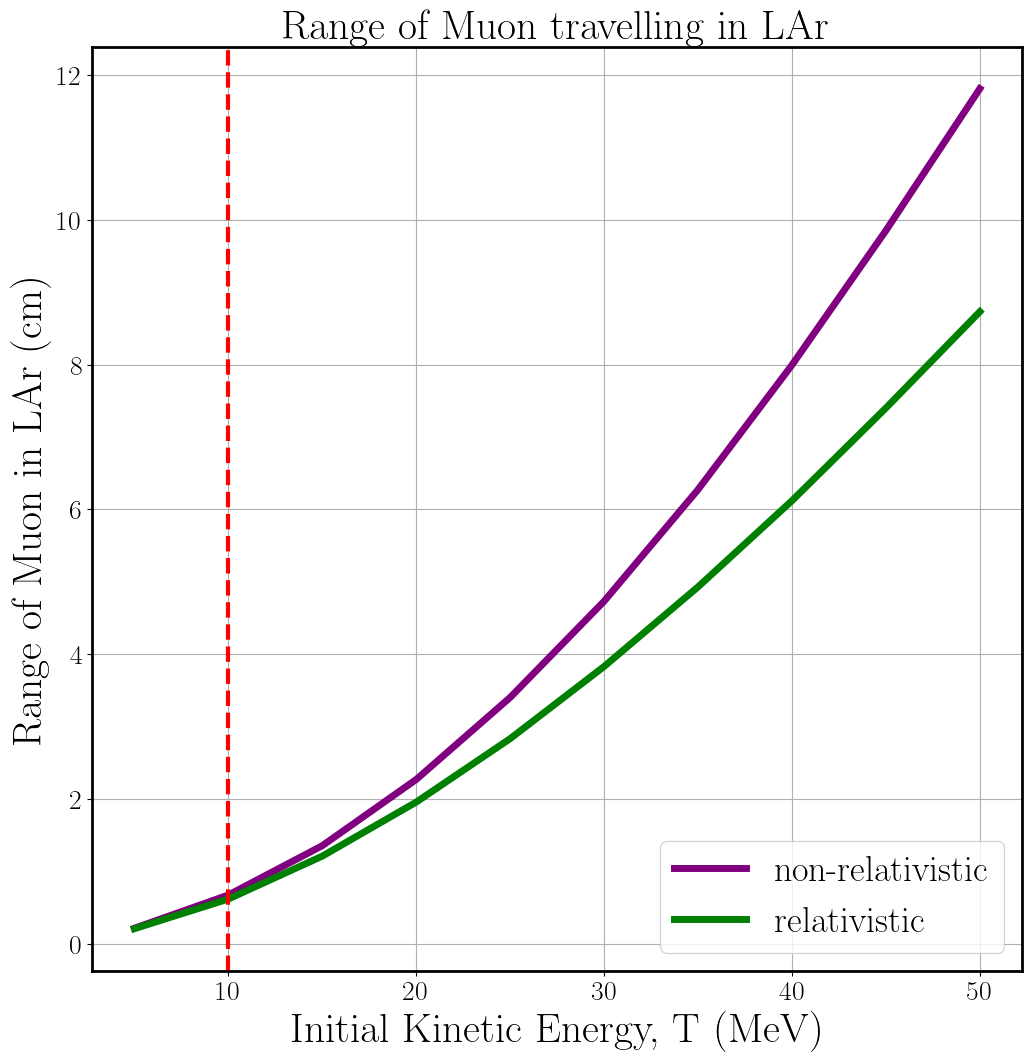

In [40]:
# Plotting the function 

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_title("Range of Muon travelling in LAr", fontsize=30)
plt.plot(t,nonrel_list, c='purple',label='non-relativistic',lw=5)
plt.plot(t,rel_list, c='green',label='relativistic',lw=5)
plt.axvline(10,ls='--',c='red',lw=3)
plt.grid()

ax.set_ylabel("Range of Muon in LAr (cm)",fontsize=30)
ax.set_xlabel('Initial Kinetic Energy, T (MeV)',fontsize=30)
plt.legend(fontsize=24)

plt.yticks(fontsize=20), plt.xticks(fontsize=20)

ax.legend(fontsize=26)

plt.savefig("Range_Muon_LAr_rel_vs_nonrel.jpg", bbox_inches= 'tight')
plt.show()

((array([-100.,    0.,  100.,  200.,  300.,  400.,  500.]),
  <a list of 7 Text yticklabel objects>),
 (array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
  <a list of 8 Text xticklabel objects>))

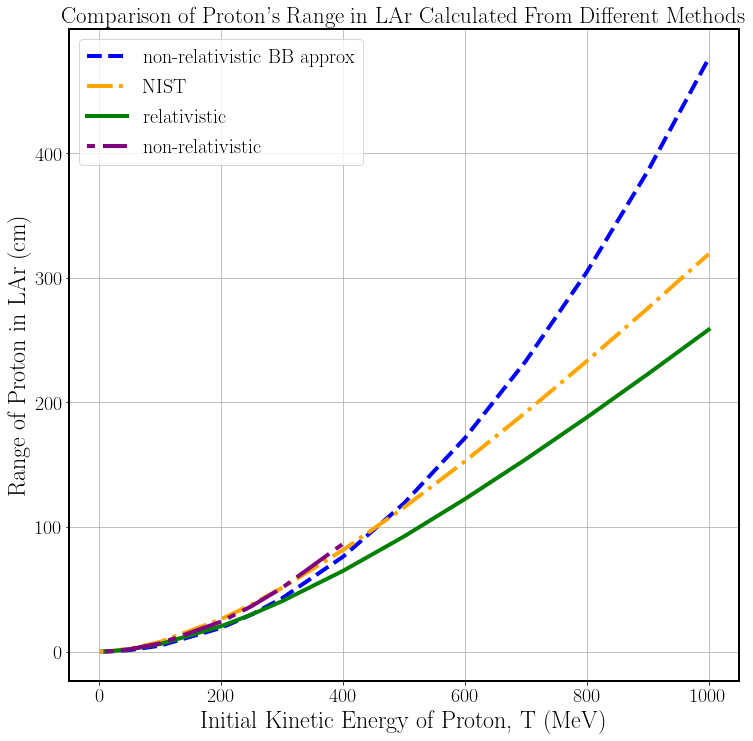

In [57]:
#Plotting the range of Proton from Relativistic/Nonrelativistic apprx to compare with NIST values.

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ax.set_title("Comparison of Proton's Range in LAr Calculated From Different Methods", fontsize=23)
plt.grid()

# 'densely dashdotted',    (0, (3, 1, 1, 1)))
plt.plot(data_t, data_x_db, ls= 'dashed', c='blue',label='non-relativistic BB approx',lw=4)
plt.plot(data_t, data_x_or, ls= 'dashdot', c='orange',label='NIST',lw=4)
plt.plot(data_t, data_x_gr, c='green',label='relativistic',lw=4)
plt.plot(data_t, data_x_lb, dashes = [2, 2, 10, 2], c='purple',label='non-relativistic',lw=4)

ax.set_xlabel("Initial Kinetic Energy of Proton, T (MeV)",fontsize=24)
ax.set_ylabel('Range of Proton in LAr (cm)',fontsize=24)
plt.legend(fontsize=20)

plt.yticks(fontsize=20), plt.xticks(fontsize=20)
# plt.show()

# plt.savefig("range_Proton_LAr_allmethods.jpg", bbox_inches='tight')

# data_x_gr

((array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350.]),
  <a list of 9 Text yticklabel objects>),
 (array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
  <a list of 8 Text xticklabel objects>))

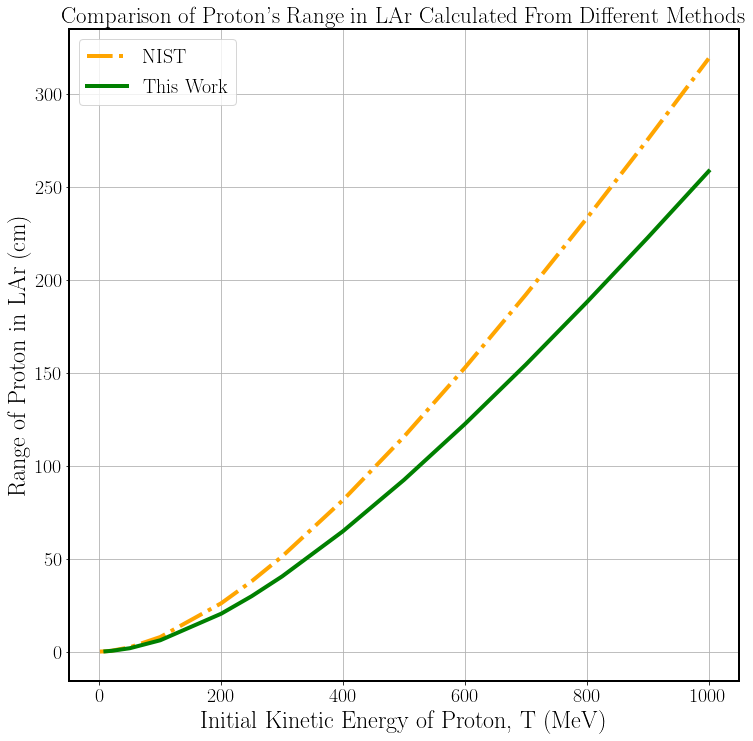

In [58]:
#Plotting the range of Proton from Relativistic/Nonrelativistic apprx to compare with NIST values.

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ax.set_title("Comparison of Proton's Range in LAr Calculated From Different Methods", fontsize=23)
plt.grid()

# 'densely dashdotted',    (0, (3, 1, 1, 1)))
# plt.plot(data_t, data_x_db, ls= 'dashed', c='blue',label='non-relativistic BB approx',lw=4)
plt.plot(data_t, data_x_or, ls= 'dashdot', c='orange',label='NIST',lw=4)
plt.plot(data_t, data_x_gr, c='green',label='This Work',lw=4)
# plt.plot(data_t, data_x_lb, dashes = [2, 2, 10, 2], c='purple',label='non-relativistic',lw=4)

ax.set_xlabel("Initial Kinetic Energy of Proton, T (MeV)",fontsize=24)
ax.set_ylabel('Range of Proton in LAr (cm)',fontsize=24)
plt.legend(fontsize=20)

plt.yticks(fontsize=20), plt.xticks(fontsize=20)
# plt.show()

# plt.savefig("range_Proton_LAr_nistvsours.jpg", bbox_inches='tight')

# data_x_gr

In [59]:
#Importing a CSV File into Python using Pandas
import pandas as pd
range = pd.read_csv (r'C:\Users\hrrah\Desktop\HEP\Cerenkov\range_proton.csv')
range

,T_0 (MeV),x_lb,x_db,x_or,x_gr
0,1,NaN,0.000,0.003,NaN
1,10,0.129,0.048,0.135,0.127
2,20,0.400,0.190,0.454,0.391
3,50,1.880,1.190,2.299,1.801
4,100,6.621,4.762,7.826,6.080
5,200,24.059,19.048,25.993,20.379
6,250,36.492,29.762,37.853,29.804
7,300,51.201,42.857,51.197,40.462
8,400,86.574,76.190,81.554,64.814
9,500,NaN,119.048,115.666,92.404


In [60]:
#Calling the columns of data table by their headers 
t_0 = range["T_0 (MeV)"]
x_nonrel1 = range["x_lb"] #light blue in Excel=> our apprx => purple in python plot 
x_nonrel2 = range["x_db"] #dark blue in Excel=> previous (HW2) apprx
x_nist = range["x_or"] #NIST Range => Orange 
x_rel = range["x_gr"] #full relativistic approach => Green 

ratio1 = x_nonrel1/x_rel
ratio2 = x_nonrel2/x_rel
ratio3 = x_nist/x_rel
ratio4 = x_rel/x_rel

# t_0,ratio1,ratio2,ratio3

In [ ]:
#Plotting the ratio of range of Proton calculated from Relativistic/Nonrelativistic apprx to compare with NIST values.

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_title("Ratio of ranges of Proton travelling in LAr", fontsize=24)
plt.grid()


plt.plot(t_0, ratio1, c='purple',label='non-relativistic/relativistic',lw=4)
plt.plot(t_0, ratio2, c='blue',label='non-relativistic & BB approx/relativistic',lw=4)
plt.plot(t_0, ratio3, c='orange',label='NIST/relativistic',lw=4)
plt.plot(t_0, ratio4, c='green',label='relativistic',lw=4)

ax.set_xlabel("Initial Kinetic Energy of Proton, T (MeV)",fontsize=24)
ax.set_ylabel('$x/x_{relativistic}$',fontsize=24)
plt.legend(fontsize=20)

plt.yticks(fontsize=20), plt.xticks(fontsize=20)
plt.show()

# plt.savefig("ratio_Proton_LAr_allmethods.jpg")

In [62]:
#Importing a CSV File into Python using Pandas
import pandas as pd
spowerdata = pd.read_csv(r'C:\Users\hrrah\Desktop\HEP\Cerenkov\NIST_stopping_power_p_Ar.csv')
spowerdata

,T_0 (MeV),t_slope (non-rel),stopping_power (non-rel),t_slope (rel),stopping_power (rel),stopping_power (NIST)
0,1,405.30,293.70,405.81,294.06,153.00
1,10,61.15,44.31,61.98,44.91,30.60
2,20,33.68,24.41,34.61,25.08,17.90
3,50,15.12,10.96,16.19,11.73,8.78
4,100,8.20,5.94,9.37,6.79,5.21
5,200,4.46,3.23,5.72,4.14,3.25
6,250,3.68,2.67,4.97,3.60,2.83
7,300,3.17,2.29,4.46,3.23,2.56
8,400,2.59,1.88,3.83,2.78,2.21
9,500,NaN,NaN,3.46,2.50,2.00


In [63]:
# Stopping power of Proton travelling in LAr

#Calling the columns of data table by their headers 
t_0 = spowerdata["T_0 (MeV)"]
spower1 = spowerdata["stopping_power (non-rel)"] #Non-relativistic: in MeV.cm^2/gm 
spower2 = spowerdata["stopping_power (rel)"] #Relativistic: in MeV.cm^2/gm 
spower3 = spowerdata["stopping_power (NIST)"] #NIST: in MeV.cm^2/gm 

# t_0, spower3

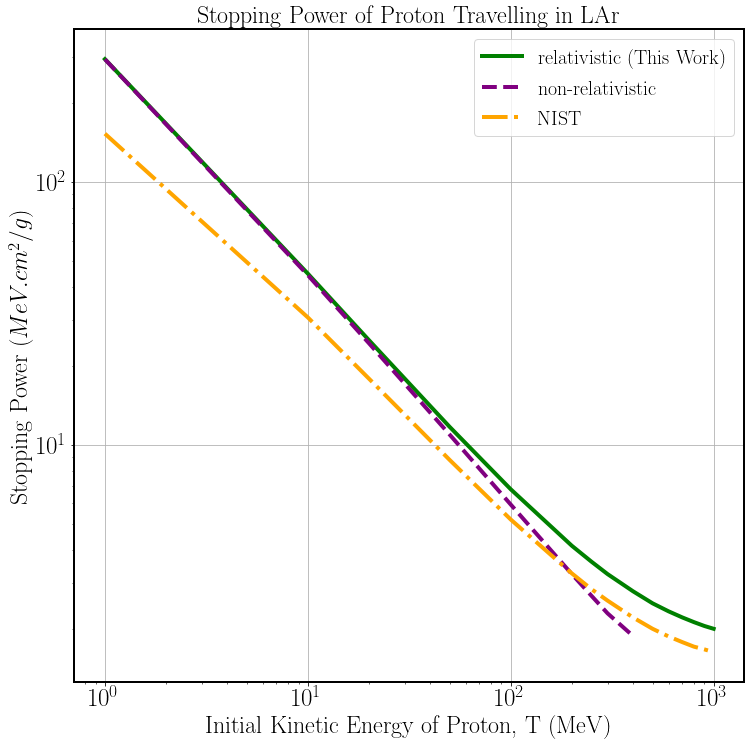

<Figure size 432x288 with 0 Axes>

In [66]:
# t_0, spower3
#Plotting the stopping power calculated from Relativistic/Nonrelativistic apprx to compare with NIST values.

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_title("Stopping Power of Proton Travelling in LAr", fontsize=24)
plt.grid()

plt.xscale("log")
plt.yscale("log")

plt.plot(t_0, spower2, c='green',label='relativistic (This Work)',lw=4)
plt.plot(t_0, spower1, ls= '--', c='purple',label='non-relativistic',lw=4)
# # plt.plot(t_0, ratio2, c='blue',label='non-relativistic & BB approx',lw=4)
plt.plot(t_0, spower3, ls= 'dashdot', c='orange',label='NIST',lw=4)

ax.set_xlabel("Initial Kinetic Energy of Proton, T (MeV)",fontsize=24)
ax.set_ylabel('Stopping Power $(MeV.cm^2/g)$',fontsize=24)
plt.legend(fontsize=20)

plt.yticks(fontsize=25), plt.xticks(fontsize=25)
plt.show()

plt.savefig("stopping_power_Proton_LAr_nistvsours.jpg", bbox_inches="tight")


In [69]:
t = np.array([1,10,20,50,100,200,250,300,400,500,600,700,800,900,1000]) #K.E of Proton  in MeV
mp = 938  #Proton's mass in MeV
beta  = np.sqrt(1 - (1/(1 + t/mp)**2)) #Relativistic Approach 
beta

array([0.04613883, 0.14486468, 0.20326783, 0.31409151, 0.42824876,
       0.56622157, 0.61367043, 0.6526336 , 0.71311572, 0.75796532,
       0.79249149, 0.81980026, 0.8418569 , 0.85997431, 0.87506571])